## Analysis of feature selection results

We tried a few different feature selection methods for mutation prediction:

* mean absolute deviation
* pan-cancer univariate f-statistic (on training data, separate samples into mutated/not mutated and do an f-test)
* median univariate f-statistic across cancer types (same as above for each individual cancer type, then take median)
* MAD of univariate f-statistic across cancer types (same as above, but look for least variable genes)

Here, we're just looking at stratified CV across all cancer types, as a sanity check - the idea is to make sure the univariate correlation-based feature selection methods perform reasonably well. This isn't necessarily where we'd expect them to help performance, but we still don't want them to _hurt_ it.

In [1]:
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import upsetplot as up
from venn import generate_petal_labels

import pancancer_evaluation.config as cfg
import pancancer_evaluation.utilities.analysis_utilities as au

%load_ext autoreload
%autoreload 2

### Load results and look at overall performance

In [2]:
# analysis of results generated by script:
# 01_stratified_classification/run_stratified_classification.py
# (with varying feature_selection parameters)

results_dir = os.path.join('results', 'univariate_fs_big', 'pancancer')
large_n_dims = 8000
small_n_dims = 1000

In [3]:
results_df = au.load_prediction_results_fs(results_dir, cfg.fs_methods)

results_df.loc[
    (results_df.fs_method == 'mad') & (results_df.n_dims == small_n_dims),
    'fs_method'
] = 'mad_{}'.format(small_n_dims)
results_df.loc[
    (results_df.fs_method == 'mad') & (results_df.n_dims == large_n_dims),
    'fs_method'
] = 'mad_{}'.format(large_n_dims)

print(results_df.shape)
print(results_df.fs_method.unique())
print(results_df.n_dims.unique())
results_df.head()

(1440, 10)
['mad_8000' 'mad_f_test' 'mad_1000' 'median_f_test' 'pancan_f_test']
[8000 1000]


,auroc,aupr,gene,holdout_cancer_type,signal,seed,data_type,fold,fs_method,n_dims
0,0.49717,0.48374,TP53,NaN,shuffled,42,train,0,mad_8000,8000
1,0.48912,0.47025,TP53,NaN,shuffled,42,test,0,mad_8000,8000
2,0.50075,0.48553,TP53,NaN,shuffled,42,cv,0,mad_8000,8000
3,0.69202,0.66608,TP53,NaN,shuffled,42,train,1,mad_8000,8000
4,0.48434,0.47192,TP53,NaN,shuffled,42,test,1,mad_8000,8000


In [4]:
compare_df = []
for fs_method in results_df.fs_method.unique():
    print(fs_method, file=sys.stderr)
    compare_df.append(
        au.compare_control_ind(results_df[results_df.fs_method == fs_method],
                               metric='aupr', verbose=True)
          .assign(fs_method=fs_method)
    )
compare_df = pd.concat(compare_df)

print(compare_df.shape)
compare_df.head()

mad_8000
mad_f_test
mad_1000
median_f_test
pancan_f_test


(240, 5)


,identifier,seed,fold,delta_aupr,fs_method
0,APC,42,0,0.51881,mad_8000
1,APC,42,1,0.59499,mad_8000
2,APC,42,2,0.61021,mad_8000
3,APC,42,3,0.58726,mad_8000
4,APC,1,0,0.52152,mad_8000


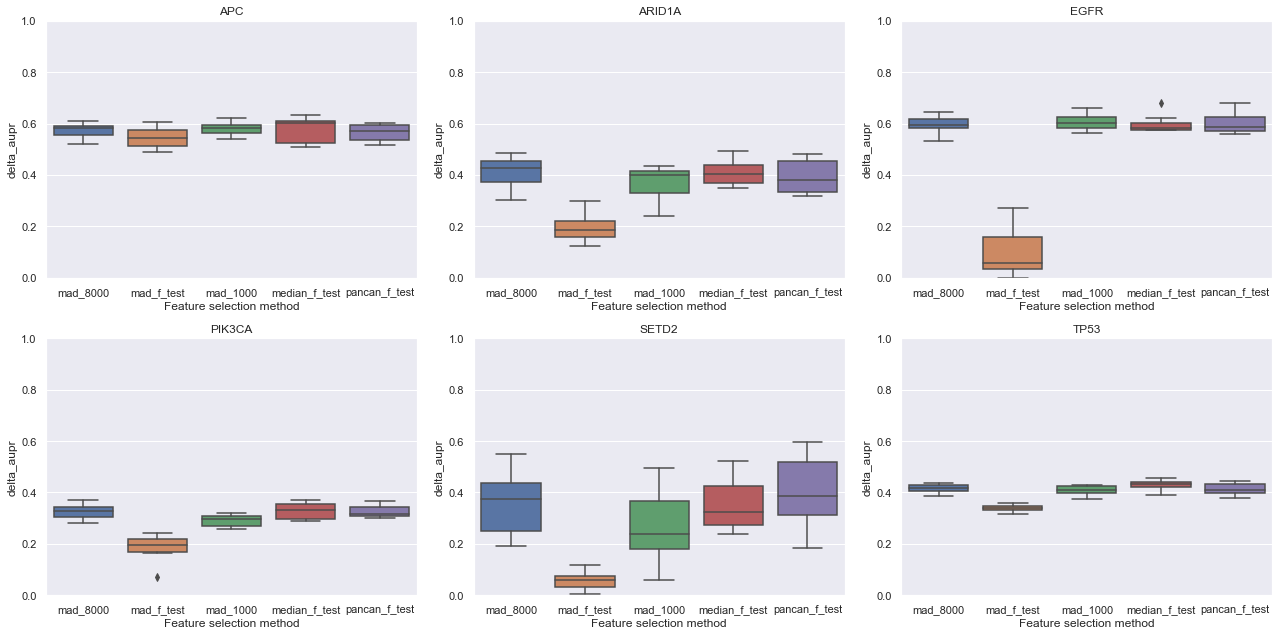

In [5]:
sns.set({'figure.figsize': (18, 9)})
sns.set_context('notebook')

fig, axarr = plt.subplots(2, 3)

for ix, gene in enumerate(compare_df.identifier.unique()):
    ax = axarr[ix // 3, ix % 3]
    plot_df = compare_df[compare_df.identifier == gene]
    sns.boxplot(data=plot_df, x='fs_method', y='delta_aupr', ax=ax)
    ax.set_title(gene)
    ax.set_xlabel('Feature selection method')
    ax.set_ylim(0, 1)

plt.tight_layout()

We can see that the blue box (median f-test) and the purple box (pan-cancer f-test) are reasonably similar in most cases to the green box (no feature selection from 1000 features), suggesting that selecting features by f-statistic doesn't seem to harm performance, at the very least. This is good.

We chose these six genes mainly because we made accurate predictions for these genes in the previous project, and they all have quite a few (>5 or so) cancer types included in the model. The goal of our feature selection experiments is (eventually) to train models that generalize across cancer types, so these genes seemed like a decent place to start.

### Further analysis of selected features

We want to look at:
* Overlap of features in at least one model (for different FS methods)
* f-statistic distributions for features in at least one model

In [6]:
# gene to analyze features for
gene = 'TP53'

id_coefs_info = []
for identifier, coefs_list in au.generate_nonzero_coefficients_fs(
        results_dir, cfg.fs_methods):
    if not identifier.startswith(gene): continue
    for fold_no, coefs in enumerate(coefs_list):
        id_coefs_info.append([identifier, fold_no, coefs])
        
print(len(id_coefs_info))

40


In [7]:
# id_coefs_info is a list where each entry has the format:
# [feature selection method, fold, list of nonzero coefficients]
print(len(id_coefs_info[0]))
print(id_coefs_info[0][:2], id_coefs_info[0][2][:5])

3
['TP53_mad_n1000', 0] [('1026', -0.63774), ('CESC', -0.57792), ('3178', -0.28324), ('5098', -0.25287), ('9518', -0.23886)]


In [8]:
# list of sets, one for each feature selection method, of
# features that were selected in at least one cross-validation fold
fs_method_coefs = {}
for coefs_list in id_coefs_info:
    identifier = coefs_list[0]
    features = list(zip(*coefs_list[2]))[0]
    if identifier in fs_method_coefs:
        fs_method_coefs[identifier].update(features)
    else:
        fs_method_coefs[identifier] = set(features)
    
print(list(fs_method_coefs.keys()))

['TP53_mad_n1000', 'TP53_pancan_f_test_n1000', 'TP53_median_f_test_n1000', 'TP53_mad_f_test_n1000', 'TP53_mad_n8000']


In [9]:
print(len(fs_method_coefs['{}_mad_n{}'.format(gene, small_n_dims)]))
print(list(fs_method_coefs['{}_mad_n{}'.format(gene, small_n_dims)])[:5])

1044
['25873', '2495', '51635', '63827', '4904']


In [10]:
def series_from_samples(samples, labels):
    """Generate the weird dataframe format that Python upsetplot expects.
    
    Use as input lists of samples, and the labels that correspond
    to each list.
    """
    # use pyvenn to generate overlaps/labels from sample IDs
    venn_labels = generate_petal_labels(samples)
    # generate format upset plot package expects
    df_ix = [[(i == '1') for i in list(b)] + [int(v)] for b, v in venn_labels.items()]
    # generate dataframe from list
    rename_map = {ix: labels[ix] for ix in range(len(labels))}
    index_names = list(rename_map.values())
    rename_map[len(labels)] = 'id'
    df = (pd.DataFrame(df_ix)
        .rename(columns=rename_map)
        .set_index(index_names)
    )
    # and return as series
    return df['id']

In [11]:
upset_series = series_from_samples(
    list(fs_method_coefs.values()), list(fs_method_coefs.keys())
)
upset_series[upset_series != 0].sort_values(ascending=False).head(5)

TP53_mad_n1000  TP53_pancan_f_test_n1000  TP53_median_f_test_n1000  TP53_mad_f_test_n1000  TP53_mad_n8000
False           False                     False                     True                   False             1750
                                                                    False                  True              1359
                True                      False                     False                  False              596
True            False                     False                     False                  False              583
False           False                     True                      False                  False              373
Name: id, dtype: int64

{'matrix': <AxesSubplot:>,
 'shading': <AxesSubplot:>,
 'totals': <AxesSubplot:>,
 'intersections': <AxesSubplot:ylabel='Intersection size'>}

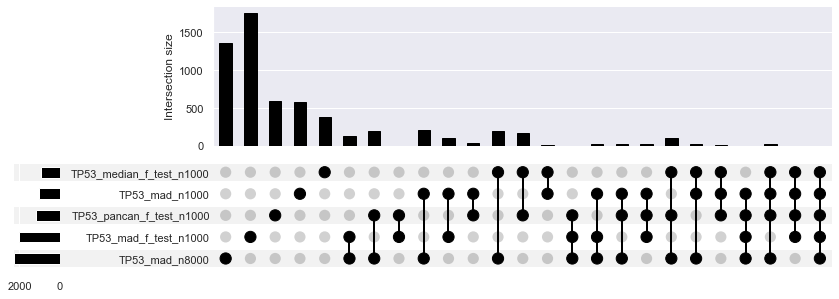

In [12]:
up.plot(upset_series[upset_series != 0])

In [13]:
fs_method_small = {
    k: v for k, v in fs_method_coefs.items() if 'mad_n{}'.format(large_n_dims) not in k
}
upset_series_small = series_from_samples(
    list(fs_method_small.values()), list(fs_method_small.keys())
)
upset_series_small[upset_series_small != 0].sort_values(ascending=False).head(5)

TP53_mad_n1000  TP53_pancan_f_test_n1000  TP53_median_f_test_n1000  TP53_mad_f_test_n1000
False           False                     False                     True                     1884
True            False                     False                     False                     785
False           True                      False                     False                     785
                False                     True                      False                     574
                True                      True                      False                     277
Name: id, dtype: int64

{'matrix': <AxesSubplot:>,
 'shading': <AxesSubplot:>,
 'totals': <AxesSubplot:>,
 'intersections': <AxesSubplot:ylabel='Intersection size'>}

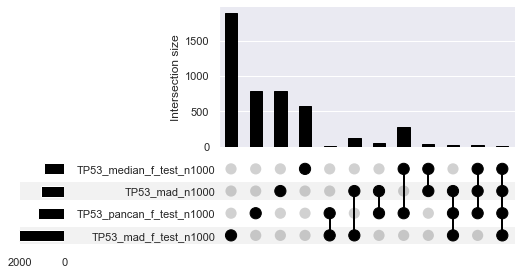

In [14]:
up.plot(upset_series_small[upset_series_small != 0])

For models where we're predicting mutation status in the given gene with various feature selection methods, this is showing the overlap in the gene expression features they selected (either the unique features for the single dots, or shared features for the connected dots in the upset plot).

Generally, we can see in the upset plots that the median and MAD methods (the ones that try to summarize/normalize across cancer types) tend to select the most distinct features relative to the other methods.

We can also see that the pan-cancer f-test and the median f-test tend to have a decent number of features in common, but not too many (much fewer than each of them alone). This is good in the sense that it means we're selecting fairly distinct features with the different methods.

### Get distribution of univariate feature correlations

NOTE: these won't be exactly what was used for feature selection since we're not doing the same train/test splits here, or filtering cancer types by mutation count -- instead we're just calculating on the whole dataset. This could and probably should be fixed in the future, the actual distributions that we're selecting features based on could be quite different.

In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import f_classif

import pancancer_evaluation.utilities.data_utilities as du

print('Loading gene label data...', file=sys.stderr)
genes_df = du.load_top_50()
sample_info_df = du.load_sample_info(verbose=True)

# this returns a tuple of dataframes, unpack it below
pancancer_data = du.load_pancancer_data(verbose=True)
(sample_freeze_df,
 mutation_df,
 copy_loss_df,
 copy_gain_df,
 mut_burden_df) = pancancer_data

rnaseq_df = du.load_expression_data(verbose=True)

# standardize columns of expression dataframe
print('Standardizing columns of expression data...', file=sys.stderr)
rnaseq_df[rnaseq_df.columns] = StandardScaler().fit_transform(rnaseq_df[rnaseq_df.columns])

Loading gene label data...
Loading sample info...
Loading pan-cancer data from cached pickle file...
Loading gene expression data...
Standardizing columns of expression data...


In [16]:
print(rnaseq_df.shape)
rnaseq_df.iloc[:5, :5]

(11060, 16148)


,1,10,100,1000,10000
sample_id,,,,,
TCGA-02-0047-01,-0.144100,-0.136450,-0.207065,1.049402,0.644625
TCGA-02-0055-01,-0.124925,-0.197893,-0.132694,0.704438,0.154763
TCGA-02-2483-01,-0.133543,-0.174587,-0.103291,1.473420,0.669303
TCGA-02-2485-01,-0.147052,-0.072888,-0.213119,4.405612,11.503035
TCGA-02-2486-01,-0.145321,-0.181076,-0.147395,1.013468,0.117745


In [17]:
y_df = (mutation_df
    .loc[:, [gene]]
    .merge(sample_freeze_df, left_index=True, right_on='SAMPLE_BARCODE')
    .drop(columns='PATIENT_BARCODE')
    .set_index('SAMPLE_BARCODE')
    .rename(columns={gene: 'status',
                     'DISEASE': 'cancer_type',
                     'SUBTYPE': 'subtype'})
)
display(y_df.shape, y_df.head())

(9074, 3)

,status,cancer_type,subtype
SAMPLE_BARCODE,,,
TCGA-02-0047-01,0,GBM,IDHwt
TCGA-02-0055-01,1,GBM,IDHwt
TCGA-02-2483-01,1,GBM,IDHmut-non-codel
TCGA-02-2485-01,1,GBM,IDHwt
TCGA-02-2486-01,0,GBM,IDHwt


In [18]:
X_df = rnaseq_df.reindex(y_df.index)

# make sure we didn't introduce any NA rows
assert X_df.isna().sum().sum() == 0

display(X_df.shape,
        X_df.isna().sum().sum(),
        X_df.iloc[:5, :5])

(9074, 16148)

0

,1,10,100,1000,10000
SAMPLE_BARCODE,,,,,
TCGA-02-0047-01,-0.144100,-0.136450,-0.207065,1.049402,0.644625
TCGA-02-0055-01,-0.124925,-0.197893,-0.132694,0.704438,0.154763
TCGA-02-2483-01,-0.133543,-0.174587,-0.103291,1.473420,0.669303
TCGA-02-2485-01,-0.147052,-0.072888,-0.213119,4.405612,11.503035
TCGA-02-2486-01,-0.145321,-0.181076,-0.147395,1.013468,0.117745


In [19]:
def get_f_stats_for_cancer_types(X_df, y_df):
    f_stats_df = {
        'pancan': f_classif(X_df, y_df.status)[0]
    }
    for cancer_type in y_df.cancer_type.unique():
        ct_samples = y_df[y_df.cancer_type == cancer_type].index
        X_ct_df = X_df.reindex(ct_samples)
        y_ct_df = y_df.reindex(ct_samples)
        
        f_stats_df[cancer_type] = f_classif(X_ct_df, y_ct_df.status)[0]
        
    return pd.DataFrame(f_stats_df, index=X_df.columns)

In [20]:
f_stats = {}

for fs_method, genes in fs_method_coefs.items():
    X_selected_df = X_df.loc[:, X_df.columns.intersection(genes)]
    f_stats_df = get_f_stats_for_cancer_types(X_selected_df, y_df)
    f_stats[fs_method] = f_stats_df
    
fs_1 = list(fs_method_coefs.keys())[0]
display(fs_1, f_stats[fs_1].iloc[:5, :5])

/home/jake/anaconda3/envs/pancancer-evaluation/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:109: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/home/jake/anaconda3/envs/pancancer-evaluation/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:109: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/home/jake/anaconda3/envs/pancancer-evaluation/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:109: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/home/jake/anaconda3/envs/pancancer-evaluation/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:109: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/home/jake/anaconda3/envs/pancancer-evaluation/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:109: RuntimeWarning

'TP53_mad_n1000'

,pancan,GBM,OV,LUAD,LUSC
1,18.832985,1.010738,0.374460,8.897974,6.801867
1001,388.248965,8.178622,0.541175,33.846306,0.114153
100133941,4.547036,0.187003,1.232441,10.350519,0.494572
10095,51.851969,1.452405,2.761299,16.318218,5.802995
10097,498.119481,0.052063,0.886655,11.098138,1.621014


TP53_mad_n1000 (33726,)
TP53_pancan_f_test_n1000 (37686,)
TP53_median_f_test_n1000 (29931,)
TP53_mad_f_test_n1000 (66462,)
TP53_mad_n8000 (75075,)


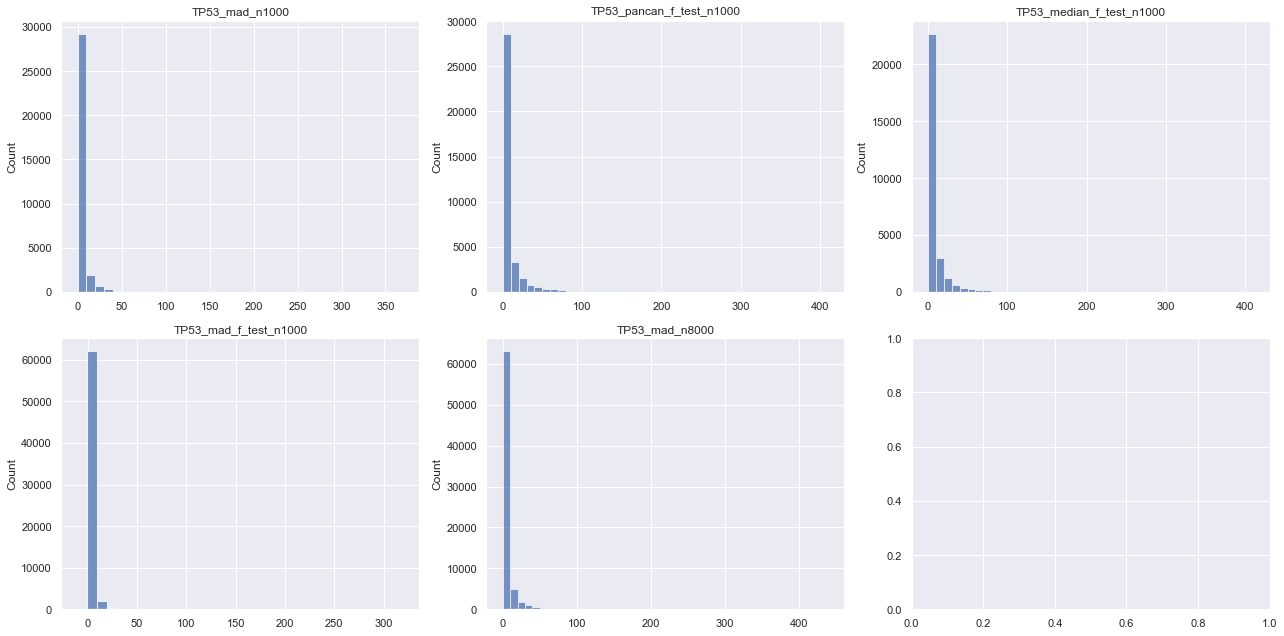

In [21]:
sns.set({'figure.figsize': (18, 9)})
sns.set_context('notebook')

fig, axarr = plt.subplots(2, 3)

for ix, (fs_method, f_stats_df) in enumerate(f_stats.items()):
    ax = axarr[ix // 3, ix % 3]
    dist_vals = (f_stats_df
        .loc[:, ~(f_stats_df.columns == 'pancan')]
        .values
        .flatten()
    )
    print(fs_method, dist_vals.shape)
    sns.histplot(dist_vals, ax=ax, binwidth=10)
    ax.set_title(fs_method)
    
plt.tight_layout()

These distributions all look pretty similar to me TBH - really we probably need to do the cancer type filtering for this analysis to make any sense.